## **Timeseries classification**

Given a timeseries dataset, we want to classify the timeseries into one of the classes. In order to reach the best result the test accuracy of some machine learning models is going to be compared. 

The task consists in classifying the timeseries in 4 different classes.

# **Data preparation**

## Get the session token

In [67]:
import http
import json
import ssl

conn = http.client.HTTPSConnection("tracker.elioslab.net", context=ssl._create_unverified_context())
## conn = http.client.HTTPSConnection("tracker.elioslab.net")
payload = json.dumps({
  "username": "LaFauci",
  "password": "LF_Password",
  "tenant": "sci-tenant"
})
headers = {
  'Content-Type': 'application/json'
}
conn.request("POST", "/v1/login", payload, headers)
res = conn.getresponse()
data = res.read()
data=json.loads(data.decode("utf-8"))
token=data['token']

## Definition of the functions

In [68]:
import json
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def get_timeseries_from_measurement(measureName):
  payload = ''
  headers = {
    'Content-Type': 'application/json',
    'Authorization': token
  }
  conn.request("GET", "/v1/measurements/"+measureName+"/timeserie?limit=2000&sort=%7B%20%22timestamp%22:%20%22asc%22%20%7D", payload, headers)
  res = conn.getresponse()
  response = res.read()
  response=json.loads(response)
  ##print(response)
  timeseries_signal=response['docs']
  return timeseries_signal

def extracting_signals(timeseries_signal, label):
    values_all = []
    for k in timeseries_signal:
        values = [k["values"][0], k["values"][1], k["values"][2], k["values"][3], k["values"][4], k["values"][5], label]
        values_all.append(values)

    ##values_all=values_all[0][10:-10]
    signal_all = np.array(values_all)
    return signal_all

def extracting_testing_signals(timeseries_signal,label,first_sample,last_sample):
    values_all = []
    for i in range(first_sample, last_sample):
        k = timeseries_signal[i]
        values = [k["values"][0], k["values"][1], k["values"][2], k["values"][3], k["values"][4], k["values"][5], label]
        # Append the extracted values to the values_all list
        values_all.append(values)
    # Convert the list of values into a numpy array
    signal_all = np.array(values_all)
    return signal_all

def preprocess_file(directory, file_name):
    file_path = os.path.join(directory, file_name)
    column_names = ["xAcc", "yAcc", "zAcc", "xGyr", "yGyr", "zGyr", "label"]
    df = pd.read_table(file_path, delimiter=" ", names=column_names)  # Use names directly for header info
    return df

def scaling(dataset):
    X = dataset.iloc[:, :-1]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=dataset.columns[:-1])
    final_df = pd.concat([X_scaled_df, dataset.iloc[:, -1].reset_index(drop=True)], axis=1)
    return final_df

def windowing(dataset, window_length):
    datasets = [dataset[i:i+window_length] for i in range(0, len(dataset) - window_length, window_length)]
    return datasets

def sliding_windowing(dataset, window_length, step_size):
    datasets = [dataset[i:i+window_length] for i in range(0, len(dataset)-window_length+1, step_size)]
    return datasets

def get_labels(dataset):
    labels = []
    for window in dataset:
        label_counts = window['label'].value_counts()
        most_common_label = label_counts.idxmax()
        labels.append(most_common_label)
    return labels

def droplbl(dataset):
    dataset_nolbl = [block.drop("label", axis=1).values.ravel() for block in dataset]
    return dataset_nolbl


## Creation of the folders to store the datasets

In [69]:
import os
if not os.path.exists("./testing"):
    os.makedirs("./testing")
if not os.path.exists("./training"):
    os.makedirs("./training")
if not os.path.exists("./validation"):
    os.makedirs("./validation")

def delete_files_in_directory(directory):
    file_list = os.listdir(directory)
    for file_name in file_list:
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)

delete_files_in_directory("./testing")
delete_files_in_directory("./validation")
delete_files_in_directory("./training")
delete_files_in_directory("./results")
delete_files_in_directory("./tuner_single_dense")

## Separation of the timeseries for training,validation and testing

In [70]:
file_names_testing = ["test-All","test2-All","test3-All"]
file_names_validation = [["test2-pistaPancaniLM","test3-pistaPancaniLM","test2-pistaBluLM"],["test7-pistaLuciaEN","test8-pistaLuciaEN","test9-pistaLuciaEN"],["test10-pistaLuciaENsp","test11-pistaLuciaENsp"],["test2-pistaAlpettaLMuo"]]
file_names_training = [["test1-pistaAlpettaLM","test2-pistaAlpettaLM","test3_pistaAlpettaLM","test-pistaAlpettaneraLM","test1-pistaPancaniLM"],["test3-pista1","test4-pistababyEN","test5-pista1EN","test5-pistababyEN","test6-pista1EN","test6-pistaLuciaENsp"],["test1-pista1ENsp","test3-pistaLuciaENsp","test4-pistaLuciaENsp","test5-pistaLuciaENsp","test8-pistaLuciaENsp","test9-pistaLuciaENsp"],["test-pistaPancaniLMuo","test-pistaBluLMuo"]]

## Extracting and saving the data

In [71]:
for label, files in enumerate(file_names_training, start=0): 
    for file in files:
        timeseries_signal = get_timeseries_from_measurement(file)
        signal_all = extracting_signals(timeseries_signal,label)
        signal_file_name = file.split('.')[0] + '.txt'
        with open(os.path.join("./training", signal_file_name), 'w') as f:
            for row in signal_all:
                f.write(' '.join(map(str, row)) + '\n')
            f.flush()

for label, files in enumerate(file_names_validation, start=0): 
    for file in files:
        timeseries_signal = get_timeseries_from_measurement(file)
        signal_all = extracting_signals(timeseries_signal,label)
        signal_file_name = file.split('.')[0] + '.txt'
        with open(os.path.join("./validation", signal_file_name), 'w') as f:
            for row in signal_all:
                f.write(' '.join(map(str, row)) + '\n')
            f.flush()

for file in file_names_testing:
    timeseries_signal = get_timeseries_from_measurement(file)
    
    if file=="test-All":
        signal_all1 = extracting_testing_signals(timeseries_signal,1,10,330)
        signal_all2 = extracting_testing_signals(timeseries_signal,2,330,410)
        signal_all3 = extracting_testing_signals(timeseries_signal,0,432,632)
        signal_all4 = extracting_testing_signals(timeseries_signal,3,626,len(timeseries_signal)-11)
        signal_all = np.concatenate((signal_all1, signal_all2, signal_all3, signal_all4), axis=0)
        ##print(len(timeseries_signal))
        signal_file_name = file.split('.')[0] + '.txt'
        with open(os.path.join("./testing", signal_file_name), 'w') as f:
            for row in signal_all:
                f.write(' '.join(map(str, row)) + '\n')
            f.flush()
            
    if file=="test2-All":
        signal_all1 = extracting_testing_signals(timeseries_signal,0,10,198)
        signal_all2 = extracting_testing_signals(timeseries_signal,3,198,292)
        signal_all3 = extracting_testing_signals(timeseries_signal,1,292,493)
        signal_all4 = extracting_testing_signals(timeseries_signal,2,505,len(timeseries_signal)-11)
        signal_all = np.concatenate((signal_all1, signal_all2, signal_all3, signal_all4), axis=0)
        ##print(len(timeseries_signal))
        signal_file_name = file.split('.')[0] + '.txt'
        with open(os.path.join("./testing", signal_file_name), 'w') as f:
            for row in signal_all:
                f.write(' '.join(map(str, row)) + '\n')
            f.flush()
           
    if file=="test3-All":
        signal_all1 = extracting_testing_signals(timeseries_signal,2,10,147)
        signal_all2 = extracting_testing_signals(timeseries_signal,3,147,268)
        signal_all3 = extracting_testing_signals(timeseries_signal,0,268,388)
        signal_all4 = extracting_testing_signals(timeseries_signal,1,393,len(timeseries_signal)-11)
        signal_all = np.concatenate((signal_all1, signal_all2, signal_all3, signal_all4), axis=0)
        ##print(len(timeseries_signal))
        signal_file_name = file.split('.')[0] + '.txt'
        with open(os.path.join("./testing", signal_file_name), 'w') as f:
            for row in signal_all:
                f.write(' '.join(map(str, row)) + '\n')
            f.flush()

## Preprocess the files

In [72]:
file_training_names = [file for file in os.listdir("./training")]
file_validation_names = [file for file in os.listdir("./validation")]
file_testing_names = [file for file in os.listdir("./testing")]

training_samples = []
training_dataset = []
for file_name in file_training_names:
    df=preprocess_file("./training", file_name)
    training_samples.append(df)
training_dataset = pd.concat(training_samples, ignore_index=True)

validation_samples = []
validation_dataset=[]
for file_name in file_validation_names:
    df = preprocess_file("./validation", file_name)
    validation_samples.append(df)
validation_dataset = pd.concat(validation_samples, ignore_index=True)

testing_samples = []
testing_dataset = []
for file_name in file_testing_names:
    df = preprocess_file("./testing", file_name)
    testing_samples.append(df)
testing_dataset = pd.concat(testing_samples, ignore_index=True)

### Scaling the dataset

In [73]:
dataset_train=scaling(training_dataset)
dataset_val=scaling(validation_dataset)
dataset_test=scaling(testing_dataset)

### Windowing

In [74]:
window_length = 15
step_size = 5

dataset_test = windowing(dataset_test, window_length)
dataset_train = sliding_windowing(dataset_train, window_length, step_size)
dataset_val = sliding_windowing(dataset_val, window_length, step_size)

### Getting the X values

In [75]:
X_train = np.array(droplbl(dataset_train))
X_val = np.array(droplbl(dataset_val))
X_test = np.array(droplbl(dataset_test))

In [76]:
print(X_val.shape[1])

90


### Getting the Y values

In [77]:
y_train = np.array(get_labels(dataset_train))
y_val = np.array(get_labels(dataset_val))
y_test = np.array(get_labels(dataset_test))

Modification in order to mix the training and the validation values before splitting then in order to take both dataset from the same data and don't have missmatches.

In [78]:
from sklearn.model_selection import train_test_split

X_train_full = np.concatenate((X_train, X_val), axis=0)
y_train_full = np.concatenate((y_train, y_val), axis=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=1)

## Print the dataset statistics

In [79]:
print("Training dataset:")
print("Samples number 0: ", np.count_nonzero(y_train == 0))
print("Samples number 1: ", np.count_nonzero(y_train == 1))
print("Samples number 2: ", np.count_nonzero(y_train == 2))
print("Samples number 3: ", np.count_nonzero(y_train == 3))

print("Validation dataset:")
print("Samples number 0: ", np.count_nonzero(y_val == 0))
print("Samples number 1: ", np.count_nonzero(y_val == 1))
print("Samples number 2: ", np.count_nonzero(y_val == 2))
print("Samples number 3: ", np.count_nonzero(y_val == 3))

print("Testing dataset:")
print("Samples number 0: ", np.count_nonzero(y_test == 0))
print("Samples number 1: ", np.count_nonzero(y_test == 1))
print("Samples number 2: ", np.count_nonzero(y_test == 2))
print("Samples number 3: ", np.count_nonzero(y_test == 3))

Training dataset:
Samples number 0:  862
Samples number 1:  774
Samples number 2:  470
Samples number 3:  197
Validation dataset:
Samples number 0:  140
Samples number 1:  144
Samples number 2:  94
Samples number 3:  29
Testing dataset:
Samples number 0:  34
Samples number 1:  47
Samples number 2:  29
Samples number 3:  19


In [80]:
linear_classifier_accuracy=[]
MLP_classifier_accuracy=[]
CNN_classifier_accuracy=[]
DCNN_classifier_accuracy=[]
NN_model_sizes=[]

# **NN models**

In this section we implement all general functions that can be used by all NN models

## Epochs and batch size configuration

In [81]:
epochs=150
batch_size=16

## Import needed libraries

In [82]:
import tracemalloc
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import joblib
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
import tensorflow as tf
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns


## Generalized functions

In [83]:
def NN_hyperparameter_fit(hyperparameter,Type_model):
  if (Type_model=="CNN"):
    model=build_model(hyperparameter)
  if (Type_model=="DCNN"):
    model=build_model_DCNN(hyperparameter)
  model.summary()
  history = model.fit(X_train, y_train, epochs=epochs,batch_size=batch_size, validation_data=(X_val, y_val))
  plot_model_performance(history,epochs)
  return model,history

In [84]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

def evaluate_NN_models(model_list):
  loss, accuracy , y_pred ,precision, recall ,f1_score ,support ,confusion_matrix_list = [], [], [], [], [], [], [], []
  for model in model_list:
    loss_value,accuracy_value=model.evaluate(X_test, y_test)
    loss.append(loss_value)
    accuracy.append(accuracy_value)
    y_pred_value=np.argmax(model.predict(X_test), axis=-1)
    y_pred.append(y_pred_value)
    precision_value, recall_value, f1_score_value, support_value = precision_recall_fscore_support(y_test , y_pred_value, average= 'macro' )
    precision.append(precision_value)
    recall.append(recall_value)
    f1_score.append(f1_score_value)
    support.append(support_value)
    confusion_matrix_value=confusion_matrix(y_test, y_pred_value)
    confusion_matrix_list.append(confusion_matrix_value)
  return [accuracy ,precision, recall ,f1_score],confusion_matrix_list,y_pred

In [85]:
from tabulate import tabulate
def print_table(data,headers):
  table_data = list(zip(*data))
  table = tabulate(table_data, headers=headers, tablefmt='grid')
  print(table)

In [86]:
def calculate_ML_size(model,file_name):
  # Create the folder if it doesn't exist
  if not os.path.exists("results"):
    os.makedirs("results")

  # Construct the complete filename with extension within the folder
  model_filename = os.path.join("results", file_name + ".joblib")

  # Save the model using joblib
  joblib.dump(model, model_filename)

  # Get the size of the saved model file
  file_size = os.path.getsize(model_filename)

  return file_size

In [87]:
def format_memory(memory_bytes):
    if memory_bytes < 1024:
        return f"{memory_bytes} B"
    elif memory_bytes < 1024 * 1024:
        return f"{memory_bytes / 1024:.2f} KB"
    elif memory_bytes < 1024 * 1024 * 1024:
        return f"{memory_bytes / (1024 * 1024):.2f} MB"
    else:
        return f"{memory_bytes / (1024 * 1024 * 1024):.2f} GB"

In [88]:
def plot_model_performance(history,number_of_epochs):
  plt.figure()
  plt.plot(history.history['loss'], 'g', label='Training Loss')
  plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

In [89]:
def plot_model_performace_accuracy(history):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
  ax1.plot(history[0].history['accuracy'], 'g', label='Training Accuracy')
  ax1.plot(history[0].history['val_accuracy'], color='orange', label='Validation Accuracy')
  ax1.set_title('training and validation')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('accuracy')
  ax1.set_ylim(0.7, 1)
  ax1.grid(True)
  ax1.legend()
  ax2.plot(history[1].history['accuracy'], 'g', label='Training Accuracy')
  ax2.plot(history[1].history['val_accuracy'], color='orange', label='Validation Accuracy')
  ax2.set_title('training and validation')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.set_ylim(0.7, 1)
  ax2.grid(True)
  ax2.legend()
  ax3.plot(history[2].history['accuracy'], 'g', label='Training Accuracy')
  ax3.plot(history[2].history['val_accuracy'], color='orange', label='Validation Accuracy')
  ax3.set_title('training and validation')
  ax3.set_xlabel('epoch')
  ax3.set_ylabel('accuracy')
  ax3.set_ylim(0.7, 1)
  plt.grid(True)
  plt.legend()
  plt.show()

In [90]:
def plot_confusion_matrix(ax, conf_matrix, title, cmap):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, cbar=False, ax=ax)
    ax.set_title(title)

def draw_confusion_matrix(matrix,name):
  colormap=["Blues","Greens","Oranges"]
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  for i in range(len(matrix)):
    plot_confusion_matrix(axes[i], matrix[i], "Confusion Matrix  "+name+ str(i+1), colormap[i])
  plt.tight_layout()
  plt.show()

In [91]:
def ML_hyperparameters_study(classifier, param_grid, X_train_ML, X_test_ML, y_train_full_ML, y_test_full_ML,random=False):
    classifier.random_state = 42
    grid_search = GridSearchCV(classifier, param_grid, cv=5, verbose=1)
    grid_search.fit(X_train_ML, y_train_full_ML)
    results = grid_search.cv_results_
    mean_training_score_all = []
    params_all = []
    testing_accuracy = []
    models_size = []
    execution_time_list = []
    total_allocated_memory=[]
    average_allocated_memory=[]
    precision_list, recall_list, f1_score_list=[],[],[]

    def fit_and_measure_memory(model, X_train_ML, y_train_full_ML):
      tracemalloc.start()
      start_time = time.time()
      model.fit(X_train_ML, y_train_full_ML)
      snapshot = tracemalloc.take_snapshot()
      tracemalloc.stop()
      end_time = time.time()
      execution_time_list.append(end_time - start_time)
      return snapshot

    for mean_score, params in zip(results['mean_test_score'], results['params']):
        mean_training_score_all.append(mean_score)
        params_all.append(params)
        hyper_model = classifier
        if random:
            hyper_model.random_state = 42
        hyper_model.set_params(**params)
        snap = fit_and_measure_memory(hyper_model, X_train_ML, y_train_full_ML)
        # Calculate the total allocated memory from the snapshot
        total_memory=sum(stat.size for stat in snap.statistics('lineno'))
        total_allocated_memory.append(format_memory(total_memory))
        # Calculate the average allocated memory
        num_snapshots = len(snap.statistics('lineno'))
        average_allocated_memory.append(format_memory(total_memory / num_snapshots))
        y_pred = hyper_model.predict(X_test_ML)
        testing_accuracy.append(accuracy_score(y_test_full_ML, y_pred))
        precision_value, recall_value, f1_score_value, support_value = precision_recall_fscore_support(y_test_full_ML , y_pred, average= 'weighted' )
        precision_list.append(precision_value)
        recall_list.append(recall_value)
        f1_score_list.append(f1_score_value)
        models_size.append(format_memory(calculate_ML_size(hyper_model, "model(" + str(mean_score) + ")")))

    best_params = grid_search.best_params_
    return [params_all,testing_accuracy,precision_list,recall_list,f1_score_list, models_size, execution_time_list,total_allocated_memory,average_allocated_memory], best_params ,mean_training_score_all

In [92]:
X_train_ML= np.array([np.array(x_train).reshape(-1) for x_train in X_train])
X_test_ML=np.array([np.array(x_test).reshape(-1) for x_test in X_test])

print('Shape:', X_train_ML.shape)
print('Type:', X_train_ML.dtype)


Shape: (2303, 90)
Type: float64


# **Linear SVM Classifier**

In [93]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
}

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='micro'),
    'recall': make_scorer(recall_score, average='micro'),
    'f1_score': make_scorer(f1_score, average='micro')
}

models_info_linear,best_params_linear,mean_training_score_all_linear = ML_hyperparameters_study(SGDClassifier(),param_grid,X_train, X_test, y_train, y_test, random=True)
headers_linear=list(param_grid.keys())

headers_linear=['models','hyperparameters',' accuracy ','precision','recall','f1_score','model size','Runtime','total allocated memory','average allocated memory']
models_name=[]
for i in range(1, len(param_grid['alpha'])+1):
  models_name.append("Linear model " + str(i))
data_linear=[models_name]
data_linear.extend(models_info_linear)
print_table(data_linear,headers_linear)
linear_classifier_accuracy=models_info_linear[1]


Fitting 5 folds for each of 6 candidates, totalling 30 fits


+----------------+-------------------+--------------+-------------+----------+------------+--------------+-----------+--------------------------+----------------------------+
| models         | hyperparameters   |    accuracy  |   precision |   recall |   f1_score | model size   |   Runtime | total allocated memory   | average allocated memory   |
+================+===================+==============+=============+==========+============+==============+===========+==========================+============================+
| Linear model 1 | {'alpha': 0.0001} |     0.395349 |    0.386732 | 0.395349 |   0.385278 | 3.92 KB      | 0.224207  | 8.84 KB                  | 232.02564102564102 B       |
+----------------+-------------------+--------------+-------------+----------+------------+--------------+-----------+--------------------------+----------------------------+
| Linear model 2 | {'alpha': 0.001}  |     0.434109 |    0.41049  | 0.434109 |   0.407879 | 3.91 KB      | 0.181798  | 9.68 K

c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Random Forest Classifier**

In [94]:
param_grid = {
    'n_estimators': [50],
    'criterion': ['gini'],
    'max_depth': [None, 5, 10, 20, 30]
}

models_info_RF,best_params_RF,mean_training_score_all_RF  = ML_hyperparameters_study(RandomForestClassifier(),param_grid,X_train, X_test, y_train, y_test,random=True)

headers_RF=['models','hyperparameters',' accuracy ','precision','recall','f1_score','model size','Runtime','total allocated memory','average allocated memory']
models_name=[]
for i in range(1, 6):
  models_name.append("RF model " + str(i))
data_RF=[models_name]
data_RF.extend(models_info_RF)
print_table(data_RF,headers_RF)
print("best hyperparameter : ", best_params_RF)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\Javie_nzb\miniconda3\envs\enviroment1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+------------+--------------------------------------------------------------+--------------+-------------+----------+------------+--------------+-----------+--------------------------+----------------------------+
| models     | hyperparameters                                              |    accuracy  |   precision |   recall |   f1_score | model size   |   Runtime | total allocated memory   | average allocated memory   |
+============+==============================================================+==============+=============+==========+============+==============+===========+==========================+============================+
| RF model 1 | {'criterion': 'gini', 'max_depth': None, 'n_estimators': 50} |     0.511628 |    0.557359 | 0.511628 |   0.477569 | 3.43 MB      |   4.29933 | 40.50 KB                 | 863.9375 B                 |
+------------+--------------------------------------------------------------+--------------+-------------+----------+------------+--------------

# **KNN Classifier**

In [95]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

models_info_KNN,best_params_KNN,mean_training_score_all_KNN = ML_hyperparameters_study(KNeighborsClassifier(),param_grid,X_train, X_test, y_train, y_test,random=False)


#### visulaize all hyperparameters with acuuracy and model size in one table

headers_KNN=['models','hyperparameters',' accuracy ','precision','recall','f1_score','model size','Runtime','total allocated memory','average allocated memory']
models_name=[]
for i in range(1, 7):
  models_name.append("KNN model " + str(i))
data_KNN=[models_name]
data_KNN.extend(models_info_KNN)
print_table(data_KNN,headers_KNN)
print("best hyperparameter : ", best_params_KNN)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
+-------------+-------------------------------------------+--------------+-------------+----------+------------+--------------+-----------+--------------------------+----------------------------+
| models      | hyperparameters                           |    accuracy  |   precision |   recall |   f1_score | model size   |   Runtime | total allocated memory   | average allocated memory   |
+=============+===========================================+==============+=============+==========+============+==============+===========+==========================+============================+
| KNN model 1 | {'n_neighbors': 3, 'weights': 'uniform'}  |     0.449612 |    0.404071 | 0.449612 |   0.41299  | 1.60 MB      |         0 | 19.85 KB                 | 1.53 KB                    |
+-------------+-------------------------------------------+--------------+-------------+----------+------------+--------------+-----------+-----------------

# **Fully connected NN (MLP)**

In [96]:
# Print the shape of the data
print("Shape of X_train:", X_train.shape)

# Number of samples
samples = X_train.shape[0]
print("Number of samples:", samples)

# Number of timesteps
timesteps = X_train.shape[1]
print("Number of timesteps:", timesteps)

features = 1

Shape of X_train: (2303, 90)
Number of samples: 2303
Number of timesteps: 90


In [97]:
from tensorflow.keras import regularizers

def build_model_fc(number_of_hidden_layers, number_of_units, num_classes, learning_rate=0.0001):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(timesteps, features)))
    for i in range(number_of_hidden_layers):
        model.add(tf.keras.layers.LSTM(number_of_units[i], return_sequences=True, kernel_regularizer=regularizers.l1(0.01)))
        model.add(tf.keras.layers.Dropout(rate = 0.3))
    model.add(tf.keras.layers.LSTM(number_of_units[-1], kernel_regularizer=regularizers.l1(0.01)))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_data=(X_val, y_val))
    return model, history

## Creating grid of hyperparameters values

In [98]:
import random

min_num_hidden_layers = 1  # Minimum number of LSTM layers
max_num_hidden_layers = 5  # Maximum number of LSTM layers
min_length = 32  # Minimum number of units in each LSTM layer
max_length = 256  # Maximum number of units in each LSTM layer
num_hidden_layers=[]
hidden_layer_lengths = []
num_layers = random.randint(min_num_hidden_layers, max_num_hidden_layers)
number_of_models=6
for _ in range(number_of_models):
    num_layers = random.randint(min_num_hidden_layers, max_num_hidden_layers)
    num_hidden_layers.append(num_layers)
    # Generate a list of random numbers between min_length and max_length
    layer_lengths = [random.randint(min_length, max_length) for _ in range(num_layers)]
    hidden_layer_lengths.append(layer_lengths)

for i in range(len(num_hidden_layers)):
  print(f"LSTM layer :{num_hidden_layers[i]} , units: {hidden_layer_lengths[i]}")

LSTM layer :4 , units: [90, 136, 168, 163]
LSTM layer :5 , units: [142, 43, 214, 117, 162]
LSTM layer :1 , units: [169]
LSTM layer :1 , units: [51]
LSTM layer :1 , units: [118]
LSTM layer :3 , units: [120, 166, 233]


## **build** and **train** 6 different MLP models each with different hyperparameters values

In [99]:
'''
models_list_MLP=[]
results_MLP=[]
for i in range(len(num_hidden_layers)):
  model,results=build_model_fc(num_hidden_layers[i],hidden_layer_lengths[i],4)
  models_list_MLP.append(model)
  results_MLP.append(results)
  plot_model_performance(results,epochs)
  '''

'\nmodels_list_MLP=[]\nresults_MLP=[]\nfor i in range(len(num_hidden_layers)):\n  model,results=build_model_fc(num_hidden_layers[i],hidden_layer_lengths[i],4)\n  models_list_MLP.append(model)\n  results_MLP.append(results)\n  plot_model_performance(results,epochs)\n  '

## Choose the best three MLP models

In [100]:
###print(len(models_list_MLP))  # Should be > 0
##print(models_list_MLP[0])  # Should print a model summary

In [101]:
'''
result_all_models_FC,confusion_matrix_FC,predicitions_FC=evaluate_NN_models(models_list_MLP)
def find_top_three_indexes(lst):
    arr = np.array(lst)
    top_indexes = arr.argsort()[-3:][::-1]
    return top_indexes

# Example usage:
top_three_indexes = find_top_three_indexes(result_all_models_FC[0])
print("Indexes of the top three values:", top_three_indexes)
'''

'\nresult_all_models_FC,confusion_matrix_FC,predicitions_FC=evaluate_NN_models(models_list_MLP)\ndef find_top_three_indexes(lst):\n    arr = np.array(lst)\n    top_indexes = arr.argsort()[-3:][::-1]\n    return top_indexes\n\n# Example usage:\ntop_three_indexes = find_top_three_indexes(result_all_models_FC[0])\nprint("Indexes of the top three values:", top_three_indexes)\n'

## Train 3 models with the entire training set:

In [102]:
'''
MLP_best_models=[models_list_MLP[top_three_indexes[0]],models_list_MLP[top_three_indexes[1]],models_list_MLP[top_three_indexes[2]]]
model1=MLP_best_models[0]
model2=MLP_best_models[1]
model3=MLP_best_models[2]
results_total_train1 = model1.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)
results_total_train2 = model2.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)
results_total_train3 = model3.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)
'''

'\nMLP_best_models=[models_list_MLP[top_three_indexes[0]],models_list_MLP[top_three_indexes[1]],models_list_MLP[top_three_indexes[2]]]\nmodel1=MLP_best_models[0]\nmodel2=MLP_best_models[1]\nmodel3=MLP_best_models[2]\nresults_total_train1 = model1.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)\nresults_total_train2 = model2.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)\nresults_total_train3 = model3.fit(X_train, y_train, epochs=epochs,batch_size=batch_size)\n'

In [103]:
'''
models_list_FC = []
models_list_FC.append(model1)
models_list_FC.append(model2)
models_list_FC.append(model3)
'''

'\nmodels_list_FC = []\nmodels_list_FC.append(model1)\nmodels_list_FC.append(model2)\nmodels_list_FC.append(model3)\n'

In [104]:
###plot_model_performace_accuracy([results_MLP[top_three_indexes[0]],results_MLP[top_three_indexes[0]],results_MLP[top_three_indexes[0]]])

## Evaluate the best three MLP models

In [105]:
'''
result_all_models_FC,confusion_matrix_FC,predicitions_FC=evaluate_NN_models(MLP_best_models)

## create a table with all models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score']

hyperparameters_values=[]
models=[]
for i in range(len(top_three_indexes)):
  hyperparameters_values.append(f"{num_hidden_layers[top_three_indexes[i]]},{hidden_layer_lengths[top_three_indexes[i]]}")
  models.append(f"MLP Model{i}")
data_normal_FC=[models]
data_normal_FC.append(hyperparameters_values)
data_normal_FC.extend(result_all_models_FC)
print_table(data_normal_FC,headers)
MLP_classifier_accuracy=result_all_models_FC[0]
'''

'\nresult_all_models_FC,confusion_matrix_FC,predicitions_FC=evaluate_NN_models(MLP_best_models)\n\n## create a table with all models results\nheaders=[\'models\',\'hyperparameter\',\'accuracy\',\'precision\',\'recall\',\'f1_score\']\n\nhyperparameters_values=[]\nmodels=[]\nfor i in range(len(top_three_indexes)):\n  hyperparameters_values.append(f"{num_hidden_layers[top_three_indexes[i]]},{hidden_layer_lengths[top_three_indexes[i]]}")\n  models.append(f"MLP Model{i}")\ndata_normal_FC=[models]\ndata_normal_FC.append(hyperparameters_values)\ndata_normal_FC.extend(result_all_models_FC)\nprint_table(data_normal_FC,headers)\nMLP_classifier_accuracy=result_all_models_FC[0]\n'

In [106]:
###draw_confusion_matrix(confusion_matrix_FC,"MLP model")

# **CNN**

In [107]:
timesteps = X_train.shape[1]
features = 1
num_classes = 4

In [108]:
def build_model(hp, kernel_size=3):

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4,1e-5])
    # Tune the optimizer
    hp_optimizer = hp.Choice('optimizer', values=['adam'])
    # Tune the number of filters in the Conv1D layer
    hp_filters = hp.Int('filters', min_value=16, max_value=64, step=8)
    # Tune the dropout values
    dropout_rate = hp.Choice('dropout', values=[0.7])
    # Tune weights initialization
    kernel_initializer = hp.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal', 'lecun_normal'])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(timesteps, features)))  # Adjusted for 1D input
    model.add(tf.keras.layers.Conv1D(filters = hp_filters , kernel_size=kernel_size, activation='relu', kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.01)))

    model.add(tf.keras.layers.Dropout(rate = dropout_rate))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.Activation('softmax'))

    # Compile the model with the hyperparameters
    model.compile(optimizer=hp_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],)
    return model

## Observe the most performing models and identify their hyperparameters:

In [109]:
# Let's use a Bayesian approach to conduct the search.
import keras_tuner
from kerastuner.tuners import BayesianOptimization 
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_single_dense',
    project_name='training_tuner_single_dense4'
)

#Let's start training models with different hyperparameters.
tuner.search(X_train, y_train, epochs=75,batch_size=batch_size, validation_data=(X_val, y_val))

Reloading Tuner from tuner_single_dense\training_tuner_single_dense4\tuner0.json


In [110]:
num_trials = 3
best_hps2 = tuner.get_best_hyperparameters(num_trials=num_trials)
for idx, hyperparameters in enumerate(best_hps2):
    print(f"Set {idx + 1}: {hyperparameters.values}")

Set 1: {'learning_rate': 0.01, 'optimizer': 'adam', 'filters': 32, 'dropout': 0.7, 'kernel_initializer': 'he_normal'}
Set 2: {'learning_rate': 0.001, 'optimizer': 'adam', 'filters': 32, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 3: {'learning_rate': 0.01, 'optimizer': 'adam', 'filters': 40, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}


In [111]:
best_hyperparameter_CNN=[best_hps2[0],best_hps2[1],best_hps2[2]]

## Train 3 CNN models and plot performance

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 88, 32)            128       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 44, 32)           0         
 1D)                                                             
                                                                 
 dense_24 (Dense)            (None, 44, 32)            1056      
                                                                 
 dense_25 (Dense)            (None, 44, 4)             132       
                                                                 
 dropout_6 (Dropout)         (None, 44, 4)             0         
                                                                 
 flatten_6 (Flatten)         (None, 176)               0         
                                                      

144/144 [==============================] - 3s 9ms/step - loss: 1.8205 - accuracy: 0.4134 - val_loss: 1.4506 - val_accuracy: 0.5676
Epoch 2/150
144/144 [==============================] - 1s 6ms/step - loss: 1.4326 - accuracy: 0.5571 - val_loss: 1.2969 - val_accuracy: 0.6044
Epoch 3/150
144/144 [==============================] - 1s 6ms/step - loss: 1.3007 - accuracy: 0.5923 - val_loss: 1.2101 - val_accuracy: 0.6216
Epoch 4/150
144/144 [==============================] - 1s 6ms/step - loss: 1.2232 - accuracy: 0.6088 - val_loss: 1.1506 - val_accuracy: 0.6265
Epoch 5/150
144/144 [==============================] - 1s 5ms/step - loss: 1.1436 - accuracy: 0.6357 - val_loss: 1.0900 - val_accuracy: 0.6658
Epoch 6/150
144/144 [==============================] - 1s 5ms/step - loss: 1.1125 - accuracy: 0.6435 - val_loss: 1.0373 - val_accuracy: 0.6904
Epoch 7/150
144/144 [==============================] - 1s 5ms/step - loss: 1.0401 - accuracy: 0.6696 - val_loss: 0.9955 - val_accuracy: 0.7002
Epoch 8/150

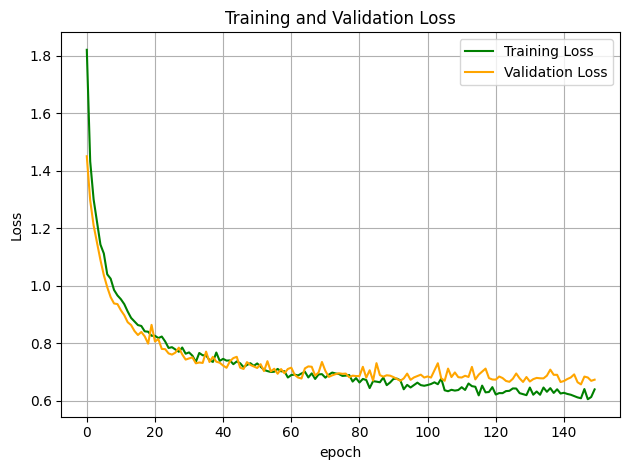

In [112]:
model4,results4=NN_hyperparameter_fit(best_hyperparameter_CNN[0],"CNN")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 88, 32)            128       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 44, 32)           0         
 1D)                                                             
                                                                 
 dense_28 (Dense)            (None, 44, 32)            1056      
                                                                 
 dense_29 (Dense)            (None, 44, 4)             132       
                                                                 
 dropout_7 (Dropout)         (None, 44, 4)             0         
                                                                 
 flatten_7 (Flatten)         (None, 176)               0         
                                                      

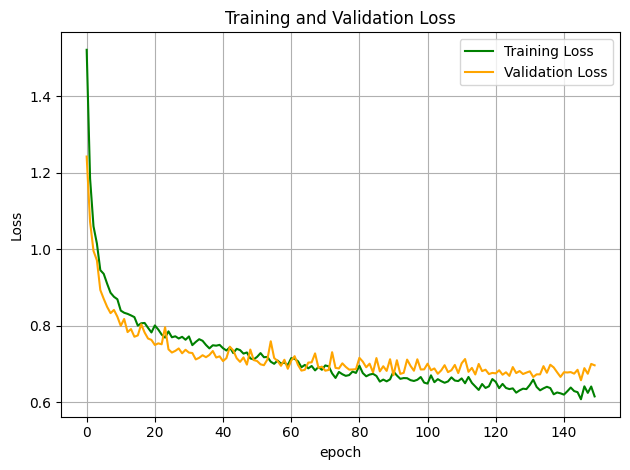

In [113]:
model5,results5=NN_hyperparameter_fit(best_hyperparameter_CNN[1],"CNN")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 88, 40)            160       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 44, 40)           0         
 1D)                                                             
                                                                 
 dense_32 (Dense)            (None, 44, 32)            1312      
                                                                 
 dense_33 (Dense)            (None, 44, 4)             132       
                                                                 
 dropout_8 (Dropout)         (None, 44, 4)             0         
                                                                 
 flatten_8 (Flatten)         (None, 176)               0         
                                                      

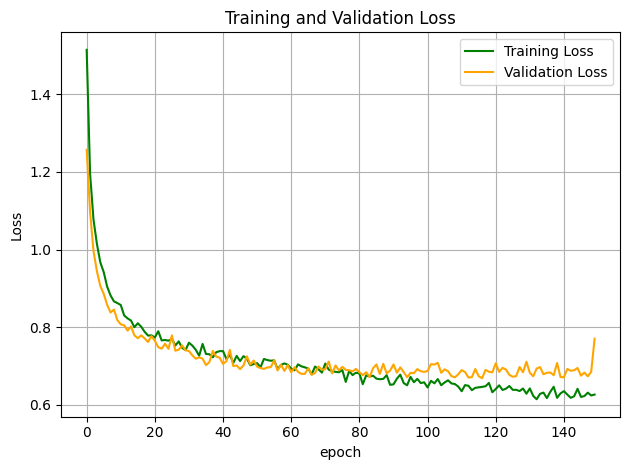

In [114]:
model6,results6=NN_hyperparameter_fit(best_hyperparameter_CNN[2],"CNN")

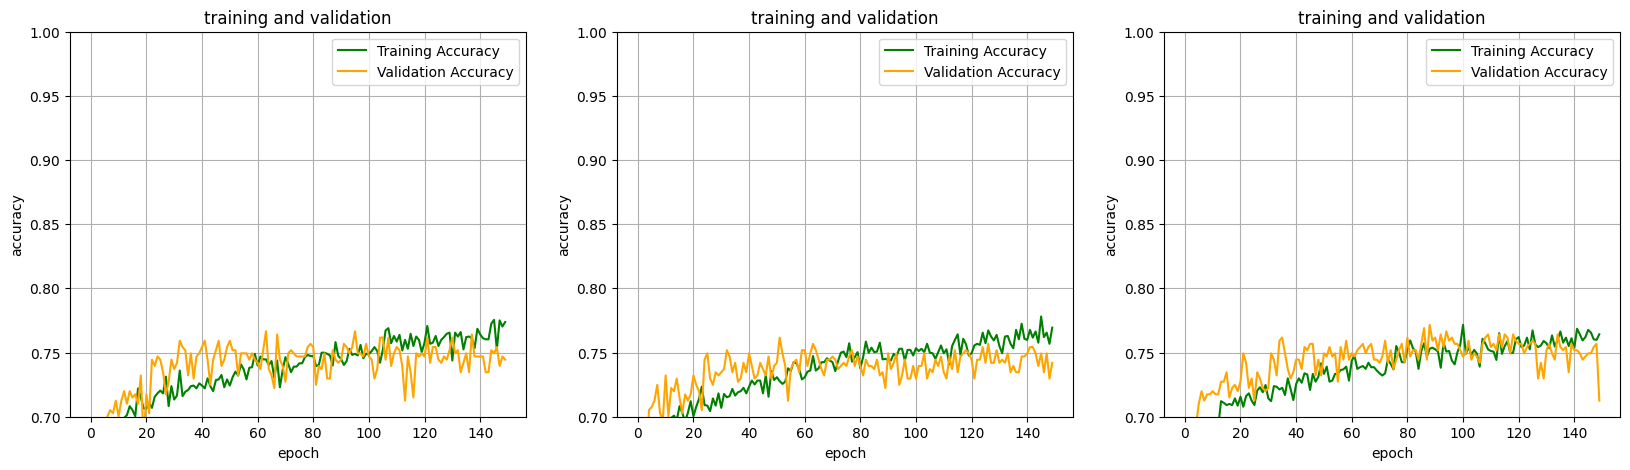

In [115]:
plot_model_performace_accuracy([results4,results5,results6])

## Let's train the three models with the entire training set:

In order to do this we need to train the models with the training and validation dataset.

In [116]:
results_total_train4 = model4.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)
results_total_train5 = model5.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)
results_total_train6 = model6.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)

Epoch 1/150
170/170 [==============================] - 1s 6ms/step - loss: 0.6459 - accuracy: 0.7576
Epoch 2/150
170/170 [==============================] - 1s 5ms/step - loss: 0.6555 - accuracy: 0.7513
Epoch 3/150
170/170 [==============================] - 1s 7ms/step - loss: 0.6469 - accuracy: 0.7590
Epoch 4/150
170/170 [==============================] - 1s 7ms/step - loss: 0.6283 - accuracy: 0.7528
Epoch 5/150
170/170 [==============================] - 1s 7ms/step - loss: 0.6382 - accuracy: 0.7572
Epoch 6/150
170/170 [==============================] - 1s 7ms/step - loss: 0.6477 - accuracy: 0.7561
Epoch 7/150
170/170 [==============================] - 1s 7ms/step - loss: 0.6484 - accuracy: 0.7446
Epoch 8/150
170/170 [==============================] - 1s 7ms/step - loss: 0.6585 - accuracy: 0.7550
Epoch 9/150
170/170 [==============================] - 1s 6ms/step - loss: 0.6560 - accuracy: 0.7502
Epoch 10/150
170/170 [==============================] - 1s 5ms/step - loss: 0.6367 - accura

In [117]:
models_list_CNN = []
models_list_CNN.append(model4)
models_list_CNN.append(model5)
models_list_CNN.append(model6)

## Evaluate the CNN models on test set:
We evaluate all the models and print out a table with all the paramaters (model, hyperparameters, accuracy, precision, recall, f1_score)

In [118]:
result_all_models_CNN,confusion_matrix_CNN,predicitions=evaluate_NN_models(models_list_CNN)
## create a table with all models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score']
data_normal_CNN=[['CNN model 1',' CNN model 2', 'CNN model 3']]
hyperparameters_values=[]
for idx, hyperparameters in enumerate(best_hyperparameter_CNN):
  hyperparameters_values.append(hyperparameters.values)
data_normal_CNN.append(hyperparameters_values)
data_normal_CNN.extend(result_all_models_CNN)
print_table(data_normal_CNN,headers)
CNN_classifier_accuracy=result_all_models_CNN[0]

5/5 [==============================] - 0s 4ms/step - loss: 1.4695 - accuracy: 0.5736


5/5 [==============================] - 0s 2ms/step
+-------------+----------------------------------------------------------------------------------------------------------------------+------------+-------------+----------+------------+
| models      | hyperparameter                                                                                                       |   accuracy |   precision |   recall |   f1_score |
+=============+======================================================================================================================+============+=============+==========+============+
| CNN model 1 | {'learning_rate': 0.01, 'optimizer': 'adam', 'filters': 32, 'dropout': 0.7, 'kernel_initializer': 'he_normal'}       |   0.573643 |    0.564255 | 0.514842 |   0.523079 |
+-------------+----------------------------------------------------------------------------------------------------------------------+------------+-------------+----------+------------+
| CNN model 2 | {'l

Now we draw a confusion matrix in order to make visible our results.

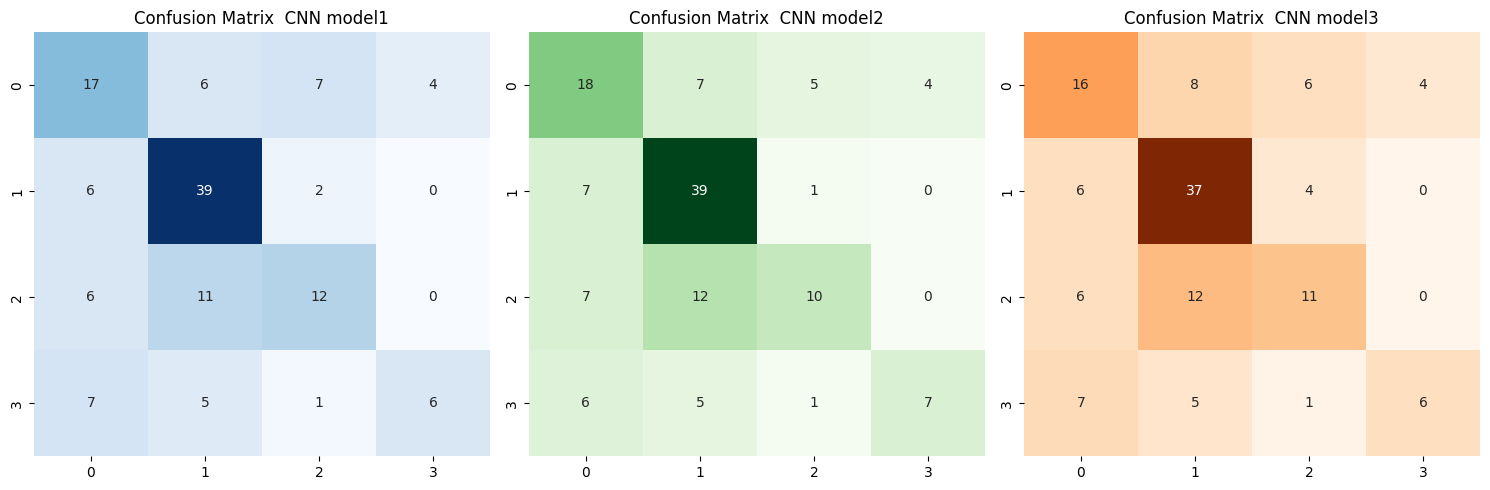

In [119]:
draw_confusion_matrix(confusion_matrix_CNN,"CNN model")

# **Deeper CNN (DCNN)**

In [120]:
timesteps = X_train.shape[1]
features = 1
num_classes = 4

In [121]:
def build_model_DCNN(hp, number_of_convolutional=2,kernal_size=[3,3]):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])
    hp_optimizer = hp.Choice('optimizer', values=['adam'])
    hp_filters = hp.Int('filters', min_value=16, max_value=64, step=8)
    dropout_rate = hp.Choice('dropout', values=[0.7])
    kernel_initializer = hp.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal', 'lecun_normal'])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(timesteps, features)))
    for i in range(number_of_convolutional - 1):
      model.add(tf.keras.layers.Conv1D(filters = hp_filters , kernel_size=kernal_size[i], activation='relu',padding='same', kernel_initializer=kernel_initializer))
      model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
      model.add(tf.keras.layers.Dropout(rate = dropout_rate))

    model.add(tf.keras.layers.Conv1D(filters = hp_filters , kernel_size=kernal_size[len(kernal_size)-1], activation='relu',padding='same', kernel_initializer=kernel_initializer))

    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=kernel_initializer)) # num_classes is the number of classes in your problem
    model.add(tf.keras.layers.Activation('softmax'))

    model.compile(optimizer=hp_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Observe the most performing models and identify their hyperparameters:

In [134]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Let's use a Bayesian approach to conduct the search.
tuner = BayesianOptimization(
    build_model_DCNN,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_single_dense',
    project_name='training_tuner_single_dense19'
)

# Let's start training models with different hyperparameters.
tuner.search(
    X_train, 
    y_train, 
    epochs=75,
    batch_size=batch_size, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

Trial 5 Complete [00h 00m 58s]
val_accuracy: 0.7592137455940247

Best val_accuracy So Far: 0.7616707682609558
Total elapsed time: 00h 03m 04s


In [123]:
num_trials = 6
best_hps_DCNN = tuner.get_best_hyperparameters(num_trials=num_trials)
for idx, hyperparameters in enumerate(best_hps_DCNN):
    print(f"Set {idx + 1}: {hyperparameters.values}")

Set 1: {'learning_rate': 0.01, 'optimizer': 'adam', 'filters': 48, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 2: {'learning_rate': 0.01, 'optimizer': 'adam', 'filters': 56, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 3: {'learning_rate': 0.01, 'optimizer': 'adam', 'filters': 24, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'}
Set 4: {'learning_rate': 0.0001, 'optimizer': 'adam', 'filters': 32, 'dropout': 0.7, 'kernel_initializer': 'he_normal'}
Set 5: {'learning_rate': 0.01, 'optimizer': 'adam', 'filters': 64, 'dropout': 0.7, 'kernel_initializer': 'lecun_normal'}


In [124]:
best_hyperparameter_DCNN=[best_hps_DCNN[0],best_hps_DCNN[1],best_hps_DCNN[2]]

## Train 3 models with the best hyperparameters and study the performance of the model with validation dataset

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 90, 48)            192       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 45, 48)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 45, 48)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 45, 48)            6960      
                                                                 
 dense_36 (Dense)            (None, 45, 32)            1568      
                                                                 
 dense_37 (Dense)            (None, 45, 4)             132       
                                                      

144/144 [==============================] - 3s 10ms/step - loss: 1.4878 - accuracy: 0.5219 - val_loss: 1.2632 - val_accuracy: 0.6167
Epoch 2/150
144/144 [==============================] - 1s 10ms/step - loss: 1.1757 - accuracy: 0.6231 - val_loss: 1.0492 - val_accuracy: 0.6683
Epoch 3/150
144/144 [==============================] - 1s 8ms/step - loss: 1.0145 - accuracy: 0.6552 - val_loss: 0.8968 - val_accuracy: 0.7224
Epoch 4/150
144/144 [==============================] - 2s 11ms/step - loss: 0.9388 - accuracy: 0.6778 - val_loss: 0.8582 - val_accuracy: 0.7273
Epoch 5/150
144/144 [==============================] - 2s 10ms/step - loss: 0.8831 - accuracy: 0.6908 - val_loss: 0.8158 - val_accuracy: 0.7297
Epoch 6/150
144/144 [==============================] - 1s 8ms/step - loss: 0.8382 - accuracy: 0.7017 - val_loss: 0.7999 - val_accuracy: 0.7420
Epoch 7/150
144/144 [==============================] - 1s 8ms/step - loss: 0.8080 - accuracy: 0.7195 - val_loss: 0.7691 - val_accuracy: 0.7568
Epoch 8

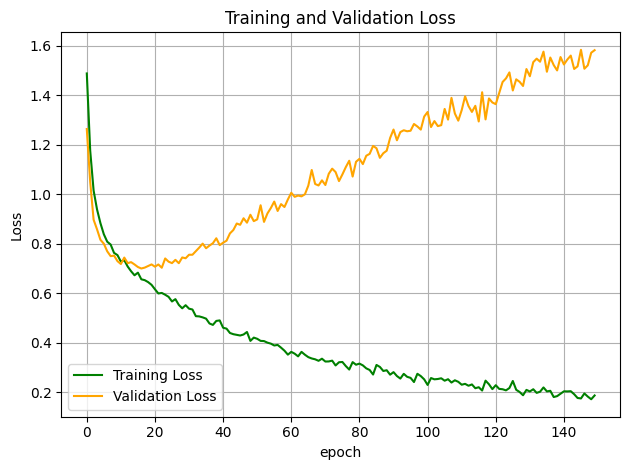

In [125]:
model7,results7=NN_hyperparameter_fit(best_hyperparameter_DCNN[0],"DCNN")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 90, 56)            224       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 45, 56)           0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 45, 56)            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 45, 56)            9464      
                                                                 
 dense_40 (Dense)            (None, 45, 32)            1824      
                                                                 
 dense_41 (Dense)            (None, 45, 4)             132       
                                                     

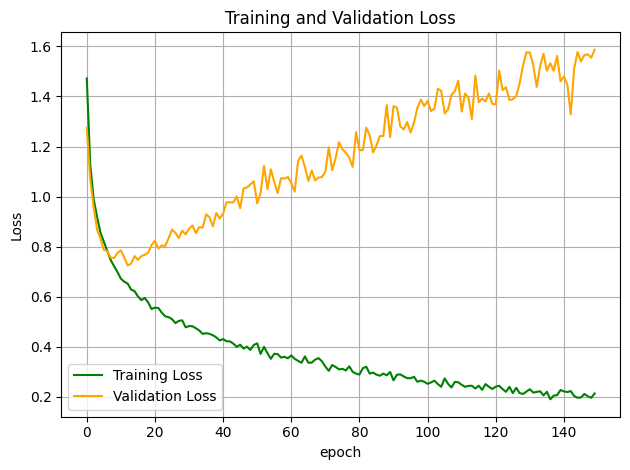

In [126]:
model8,results8=NN_hyperparameter_fit(best_hyperparameter_DCNN[1],"DCNN")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 90, 24)            96        
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 45, 24)           0         
 g1D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 45, 24)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 45, 24)            1752      
                                                                 
 dense_44 (Dense)            (None, 45, 32)            800       
                                                                 
 dense_45 (Dense)            (None, 45, 4)             132       
                                                     

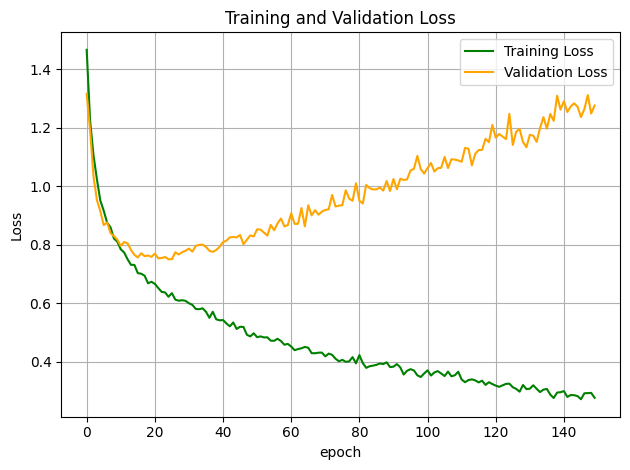

In [127]:
model9,results9=NN_hyperparameter_fit(best_hyperparameter_DCNN[2],"DCNN")

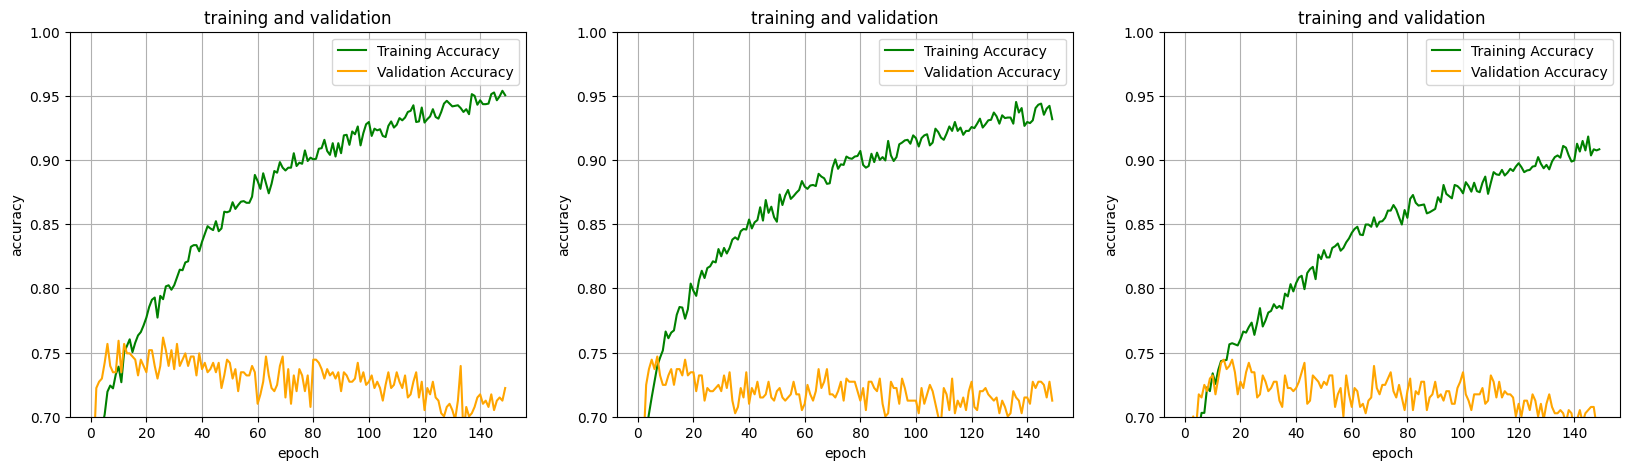

In [128]:
plot_model_performace_accuracy([results7,results8,results9])

## Train the model on all the entire dataset

In [129]:
results_total_train7 = model7.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)
results_total_train8 = model8.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)
results_total_train9 = model9.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)

Epoch 1/150
  1/170 [..............................] - ETA: 0s - loss: 0.1795 - accuracy: 0.9375

170/170 [==============================] - 1s 7ms/step - loss: 0.4069 - accuracy: 0.9030
Epoch 2/150
170/170 [==============================] - 1s 6ms/step - loss: 0.3237 - accuracy: 0.9096
Epoch 3/150
170/170 [==============================] - 1s 7ms/step - loss: 0.3049 - accuracy: 0.9232
Epoch 4/150
170/170 [==============================] - 1s 6ms/step - loss: 0.2946 - accuracy: 0.9085
Epoch 5/150
170/170 [==============================] - 1s 7ms/step - loss: 0.2799 - accuracy: 0.9122
Epoch 6/150
170/170 [==============================] - 1s 7ms/step - loss: 0.2817 - accuracy: 0.9151
Epoch 7/150
170/170 [==============================] - 1s 7ms/step - loss: 0.2657 - accuracy: 0.9225
Epoch 8/150
170/170 [==============================] - 1s 6ms/step - loss: 0.2521 - accuracy: 0.9255
Epoch 9/150
170/170 [==============================] - 1s 6ms/step - loss: 0.2548 - accuracy: 0.9229
Epoch 10/150
170/170 [==============================] - 1s 7ms/step - loss: 0.2528 - accuracy: 0.9173
E

In [130]:
models_list_DCNN = []
models_list_DCNN.append(model7)
models_list_DCNN.append(model8)
models_list_DCNN.append(model9)

## Evaluate All models and print out a table with all parameters (model , hyperparameter, accyracy, precision, recall, f1_score)

In [131]:
result_all_models_DCNN,confusion_matrix_DCNN,predicitions=evaluate_NN_models(models_list_DCNN)
## create a table with all models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score']
data_normal_DCNN=[['DCNN model 1',' DCNN model 2', 'DCNN model 3']]
hyperparameters_values=[]
for idx, hyperparameters in enumerate(best_hyperparameter_DCNN):
  hyperparameters_values.append(hyperparameters.values)
data_normal_DCNN.append(hyperparameters_values)
data_normal_DCNN.extend(result_all_models_DCNN)
print_table(data_normal_DCNN,headers)
DCNN_classifier_accuracy=result_all_models_DCNN[0]

5/5 [==============================] - 0s 4ms/step - loss: 3.9045 - accuracy: 0.5426


5/5 [==============================] - 0s 4ms/step
+--------------+---------------------------------------------------------------------------------------------------------------------+------------+-------------+----------+------------+
| models       | hyperparameter                                                                                                      |   accuracy |   precision |   recall |   f1_score |
+==============+=====================================================================================================================+============+=============+==========+============+
| DCNN model 1 | {'learning_rate': 0.01, 'optimizer': 'adam', 'filters': 48, 'dropout': 0.7, 'kernel_initializer': 'glorot_uniform'} |   0.542636 |    0.528848 | 0.52245  |   0.523799 |
+--------------+---------------------------------------------------------------------------------------------------------------------+------------+-------------+----------+------------+
| DCNN model 2 | {'

Draw confusion matrix

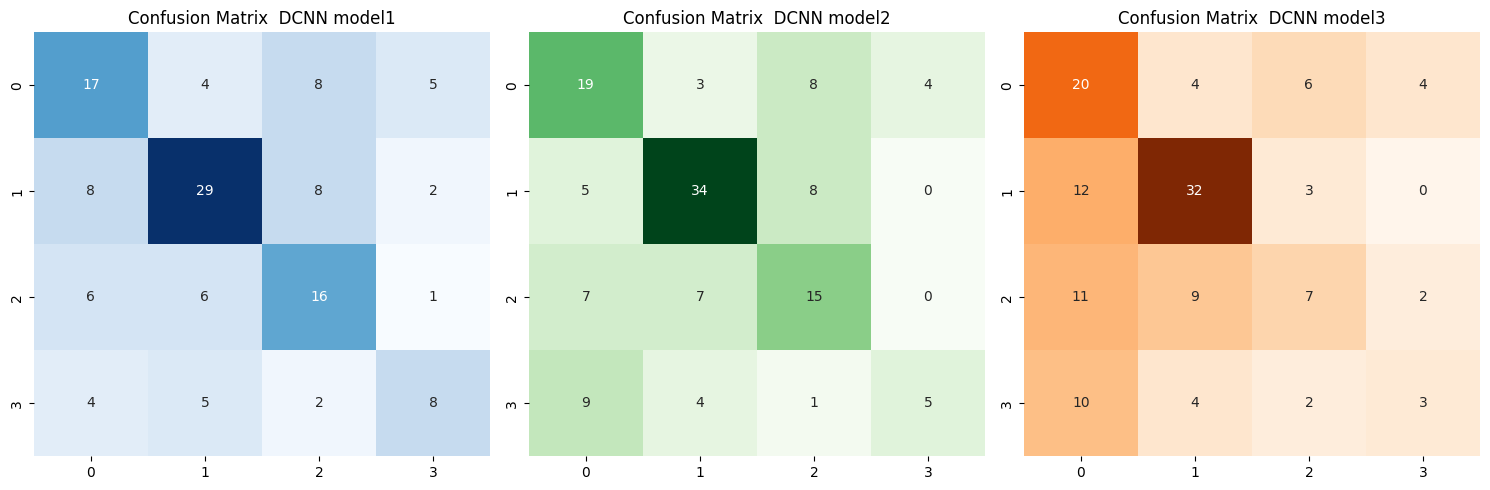

In [132]:
draw_confusion_matrix(confusion_matrix_DCNN,"DCNN model")

# **TensorFlow Lite model**


## Functions to evaluate and print analysis for  TFlite / quantized models

In [ ]:
import numpy as np

def evaluate(model_file, X, y, categoricalAccuarcy):
    if(categoricalAccuarcy):
      accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    else:
      accuracy = tf.keras.metrics.BinaryAccuracy()

    interpreter = tf.lite.Interpreter(model_path = model_file)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    y_preds = []  # To store the predicted labels
    y_real = []

    for x, y_true in zip(X,y):
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            x = x / input_scale + input_zero_point
        x = np.expand_dims(x, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], x)
        interpreter.invoke()
        y_pred = interpreter.get_tensor(output_details["index"])[0]
        accuracy.update_state(y_true, y_pred)
         # Collect the predicted labels
        if(categoricalAccuarcy):
            y_preds.append(np.argmax(y_pred))
        else:
            y_preds.append(np.round(y_pred[0]))

        y_real.append(y_true)
    return accuracy.result(), y_preds, y_real